In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    plot_spatial_priors,
    plot_velocity_magnitude,
    postprocess_mcmc_results,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [10]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 5  # Number of MCMC chains
CORES = 5  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-22"
reference_end_date = "2024-06-22"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Parse various parameters from config file (or set manually here)
variables_names = ["V", "y"]
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=True,
    tails_percentile=0.01,
    min_velocity=1,
    apply_2d_median=False,
    median_window_size=5,
    median_threshold_factor=3,
    apply_2d_gaussian=True,
    gaussian_sigma=1.0,
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}_multiscale"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
print(dic_analyses)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)


2025-09-23 17:55:54 | [INFO    ] Found 1 DIC analyses matching criteria


   dic_id camera_name          master_timestamp           slave_timestamp  \
0    1805   PPCX_Tele 2024-06-19 06:00:19+00:00 2024-06-22 06:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34195           34223        72  


In [11]:
# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

2025-09-23 17:55:55 | [INFO    ] Fetched DIC data for id 1805 with 3927 points
2025-09-23 17:55:55 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-23 17:55:55 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-23 17:55:55 | [INFO    ] Percentile filtering: 3927 -> 3848 points (removed 79 outliers)
2025-09-23 17:55:55 | [INFO    ] Min velocity filtering: 3848 -> 3093 points (removed 755 points below 1)
2025-09-23 17:55:55 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1.0
2025-09-23 17:55:55 | [INFO    ] Estimated grid spacing: 64.00
2025-09-23 17:55:55 | [INFO    ] Created 2D grid: (75, 51), 3093 valid points
2025-09-23 17:55:55 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-23 17:55:55 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3093 points (removed 834 total)
2025-09-23 17:55:55 | [INFO    ] Data shape after filtering and stacking: (3093, 5)


In [12]:
# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)


2025-09-23 17:55:55 | [INFO    ] Filtered 3093 points to 2690 points inside polygon


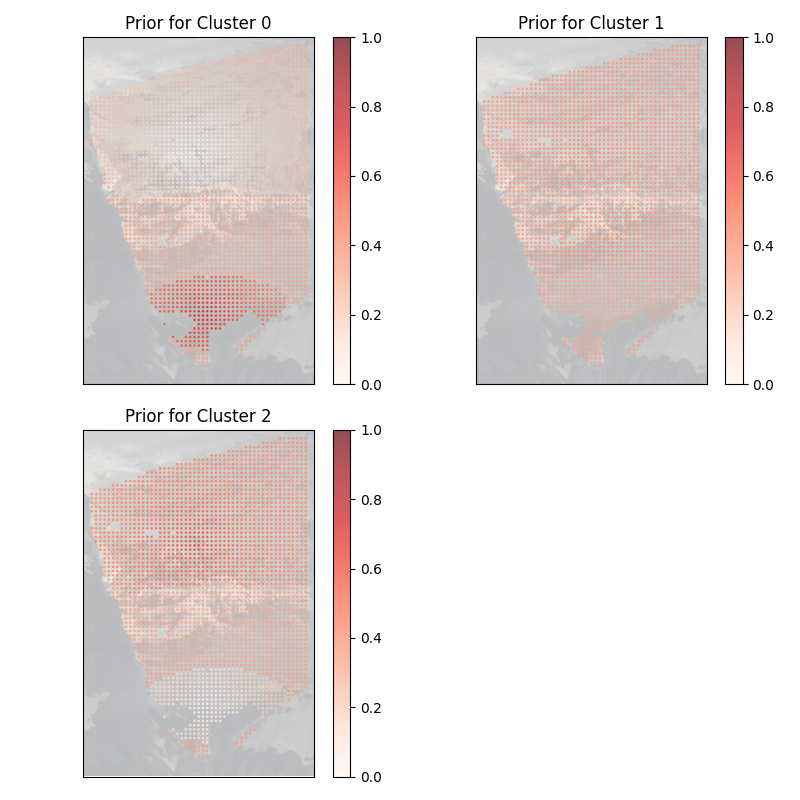

In [13]:
base_name = f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}"

# Run for unsmoothed data
df_run = df.copy()

# Assign spatial priors
prior_probs = assign_spatial_priors(
    x=df_run["x"].to_numpy(),
    y=df_run["y"].to_numpy(),
    polygons=sectors,
    prior_probs=PRIOR_PROBABILITY,
    method="exponential",
    method_kws={"decay_rate": 0.001},
)

fig, axes = plot_spatial_priors(df_run, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

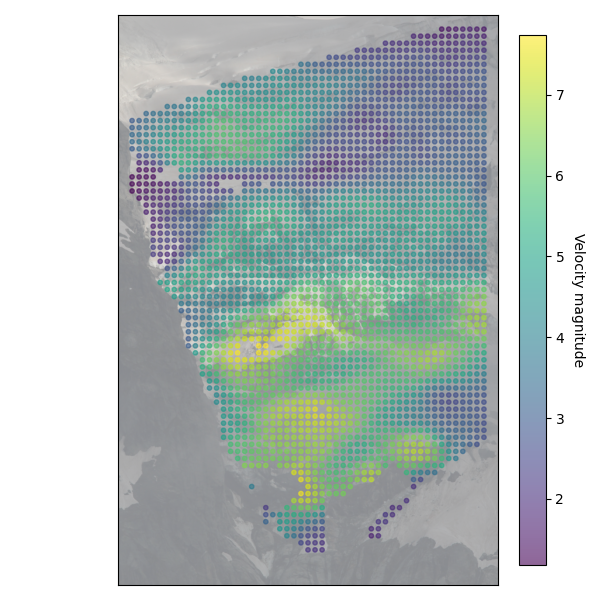

In [14]:
# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df_run["x"].to_numpy(),
    df_run["y"].to_numpy(),
    df_run["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)


In [15]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on data
df_run["log_y"] = np.log(df_run["y"] + 1e-6)
# variables_names = ["V", "log_y"]
variables_names = ["V"]

# Fit scaler on data
scaler = StandardScaler()
scaler.fit(df_run[variables_names].values)
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
logger.info(
    f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
)

# Scale data for model input
data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

# diagnostic data before building the model
print("Data statistics after scaling:")
print(f"Mean: {data_array_scaled.mean(axis=0)}")
print(f"Std: {data_array_scaled.std(axis=0)}")
print(f"Min: {data_array_scaled.min(axis=0)}")
print(f"Max: {data_array_scaled.max(axis=0)}")

# Check for outliers
Q1 = np.percentile(data_array_scaled, 25, axis=0)
Q3 = np.percentile(data_array_scaled, 75, axis=0)
print(f"IQR: {Q3 - Q1}")


# print("2D Data statistics after scaling:")
# print(
#     f"V - Mean: {data_array_scaled[:, 0].mean():.3f}, Std: {data_array_scaled[:, 0].std():.3f}"
# )
# print(
#     f"y - Mean: {data_array_scaled[:, 1].mean():.3f}, Std: {data_array_scaled[:, 1].std():.3f}"
# )

# # Check correlation
# correlation = np.corrcoef(data_array_scaled.T)[0, 1]
# print(f"V-y correlation: {correlation:.3f}")

2025-09-23 17:56:05 | [INFO    ] Using features: ['V'] with shape (2690, 1)


Data statistics after scaling:
Mean: [3.80364885e-16]
Std: [1.]
Min: [-2.25825735]
Max: [2.12664541]
IQR: [1.75571804]


2025-09-23 17:57:01 | [INFO    ] Marginalized mixture model (un-sampled) created.
2025-09-23 17:57:01 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu, sigma]


Output()

Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 43 seconds.
2025-09-23 17:57:47 | [INFO    ] Sampling completed.
2025-09-23 17:57:52 | [WARNING ] This function is temporary and it will be replaced by a more structured configuration system.
2025-09-23 17:57:52 | [INFO    ] Experiment metadata saved to output/PPCX_Tele_PyMC/PPCX_mcmc_PPCX_Tele_2024-06-22_2024-06-22_metadata.json


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     1.125  0.018   1.091    1.159        0.0      0.0    8695.0   
mu[1, 0]     0.174  0.017   0.143    0.207        0.0      0.0    8392.0   
mu[2, 0]    -1.173  0.021  -1.211   -1.133        0.0      0.0    7448.0   
sigma[0, 0]  0.387  0.012   0.363    0.410        0.0      0.0   10119.0   
sigma[1, 0]  0.323  0.012   0.301    0.346        0.0      0.0   11495.0   
sigma[2, 0]  0.427  0.016   0.395    0.457        0.0      0.0    8572.0   

             ess_tail  r_hat  
mu[0, 0]       8126.0    1.0  
mu[1, 0]       8471.0    1.0  
mu[2, 0]       9115.0    1.0  
sigma[0, 0]    8254.0    1.0  
sigma[1, 0]    8984.0    1.0  
sigma[2, 0]    9328.0    1.0  


2025-09-23 17:57:58 | [INFO    ] Postprocessing outputs saved to output/PPCX_Tele_PyMC


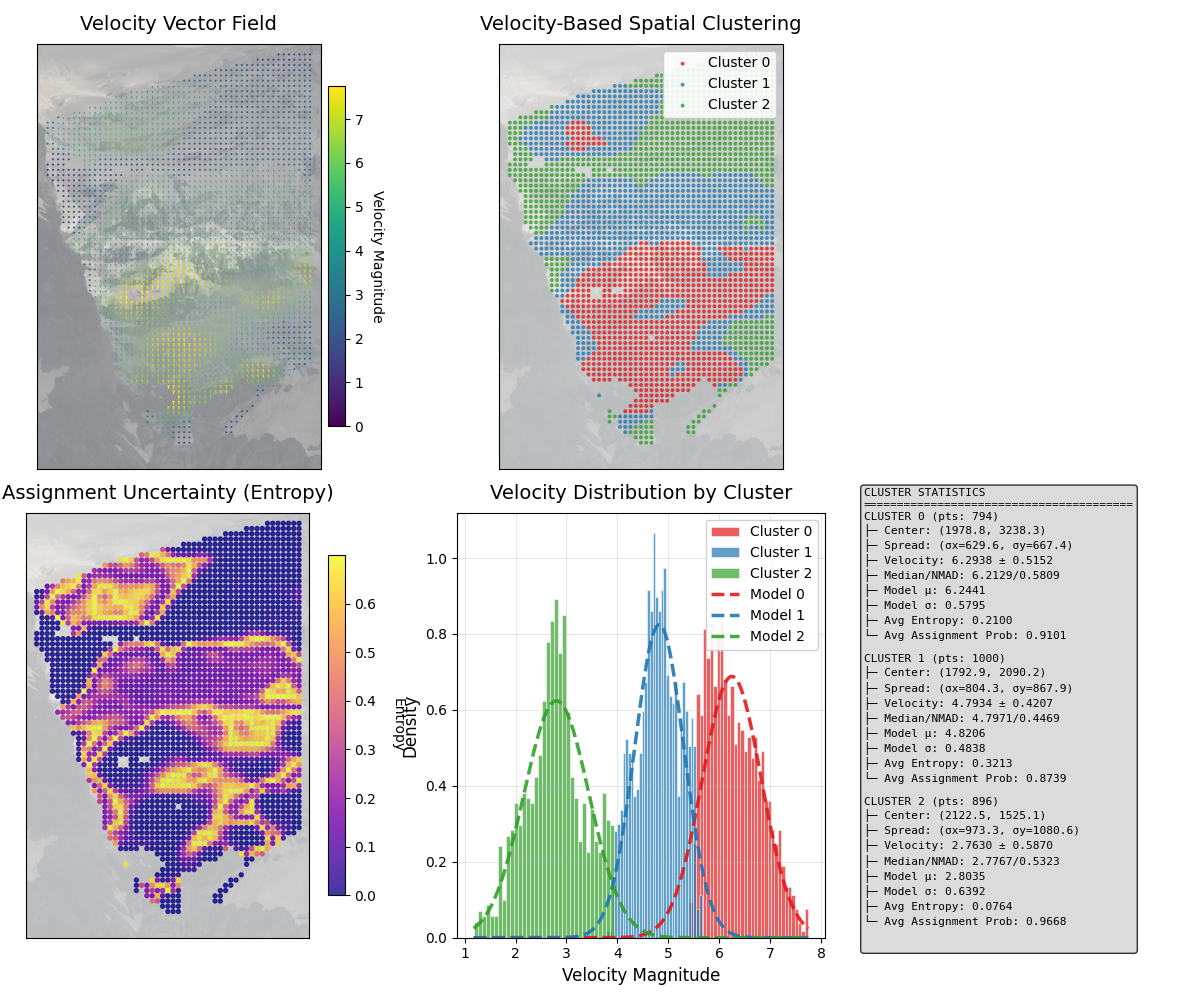

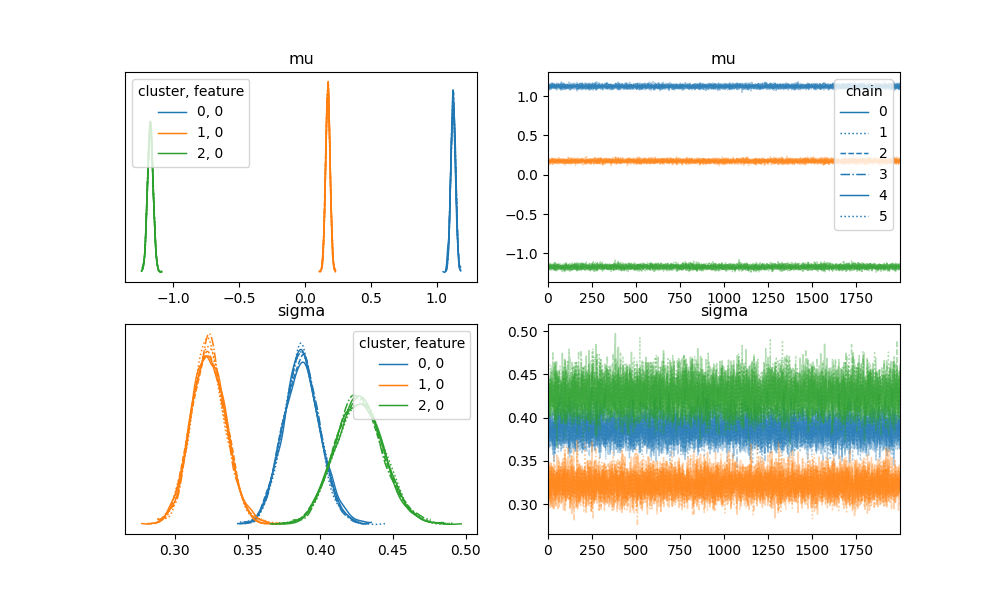

In [17]:
# Build model
model = build_marginalized_mixture_model(
    data_array_scaled,
    prior_probs,
    sectors,
    mu_params={"mu": 0, "sigma": 1},
    sigma_params={"sigma": 2},
    feature_weights=[1.0, 0.3] if len(variables_names) > 1 else None,
)

# Sample model
sample_args = dict(
    target_accept=0.95,
    draws=2000,
    tune=1000,
    chains=6,
    cores=6,
    random_seed=RANDOM_SEED,
)
idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)

idata_summary = az.summary(idata, var_names=["mu", "sigma"])
print(idata_summary)

metadata = collect_run_metadata(
    idata=idata,
    convergence_flag=convergence_flag,
    data_array_scaled=data_array_scaled,
    variables_names=variables_names,
    sectors=sectors,
    prior_probs=prior_probs,
    sample_args=sample_args,
    frame=locals(),  # Pass current local variables
)

save_run_metadata(output_dir, base_name, metadata)

# Postprocess results
posterior_probs, cluster_pred, uncertainty = postprocess_mcmc_results(
    idata,
    df_run,
    scaler,
    img,
    output_dir,
    base_name,
)
